# Bag of Visual Words Image Classification (Week 1)
## Team 1
- Alvaro Budria 1651714
- Adri Molina Rodríguez 1417666
- Sergi Masip Cabeza 1533031

> In this assignment we'll be building a pipeline for classifying images from different landscapes according to their categories (urban landscapes, forests...). For doing so, we'll consider visual features from extractors such as SIFT or KAZE. With these local features, we will obtain a global description of the images by computing a per-image global histogram representation from a dictionary or bag of visual words.

In [1]:
# Not Built-In Libraries
try:
    from yellowbrick.target import ClassBalance
    # from sklearnex import patch_sklearn
    # patch_sklearn()
except ModuleNotFoundError:
    !pip install yellowbrick
    !pip install scikit-learn-intelex
    from yellowbrick.target import ClassBalance
    from sklearnex import patch_sklearn
    patch_sklearn()

Just for Windows users.

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = '4'

In [3]:
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import accuracy_score

from utils import ClassifierBoVW, run_model_with_params, randint
from dataset import Dataset

In [4]:
PLAY_MODE = 0  # if 1, use less samples than the total amount. For playing around and trying things.
RANDOM_SEED = 42
TEST_N_SAMPLES = 120
IMSIZE = 128  # we slightly downsample the images to compensate for our lack of compute power.

## Dataset exploration

First, we will show a brief visualization summarizing the categories (labels) of the dataset and its distribution.

In [5]:
train_images_filenames = pickle.load(open('../MIT_split/train_images_filenames.dat', 'rb'))
test_images_filenames = pickle.load(open('../MIT_split/test_images_filenames.dat', 'rb'))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('../MIT_split/train_labels.dat', 'rb'))
test_labels = pickle.load(open('../MIT_split/test_labels.dat', 'rb'))

## SHUFFLE ##
both = list(zip(train_images_filenames, train_labels))
random.shuffle(both)
train_images_filenames, train_labels = zip(*both)
train_images_filenames, train_labels = list(train_images_filenames), list(train_labels)

if PLAY_MODE:
    idxs_train = np.random.choice(len(train_labels), TEST_N_SAMPLES, replace=False)[:TEST_N_SAMPLES]
    idxs_test = np.random.choice(len(test_labels), TEST_N_SAMPLES, replace=False)[:TEST_N_SAMPLES]

    train_images_filenames = np.array(train_images_filenames)[idxs_train].tolist()
    test_images_filenames = np.array(test_images_filenames)[idxs_test].tolist()
    train_labels = np.array(train_labels)[idxs_train].tolist()
    test_labels = np.array(test_labels)[idxs_test].tolist()

train_dataset = Dataset(train_images_filenames, train_labels, (IMSIZE, IMSIZE))
test_dataset = Dataset(test_images_filenames, test_labels, (IMSIZE, IMSIZE))

In [7]:
def _get_data_p(labels_list, labels):
    return [labels_list.count(x) for x in labels]

def _get_data_relative(labels_list, labels):
    return np.array([labels_list.count(x)/len(labels_list) * 100 for x in labels])

def _get_nested_data(train, test, labels):
    test = _get_data_p(test, labels)
    train = _get_data_p(train, labels)
    return np.array([[x, y] for x, y in zip(train, test)])

fig, main_axs = plt.subplots(nrows = 2, ncols=4, figsize = (32, 16))
mako_cmap = (sns.color_palette("mako", as_cmap=True))
sns.set(palette = 'mako')
labels = list(set(test_labels+train_labels))

#### BAR CHART USING YELLOWBRICK ####

axes = main_axs[0]

axes[2].set_ylim([0, 300])
axes[1].set_ylim([0, 300])
axes[0].set_ylim([0, 300])

for i in range(4):

    axes[i].set_xticks(range(len(labels)), labels=labels)
    axes[i].set_ylabel('instances count')
    plt.setp(axes[i].get_xticklabels(), fontsize=10, rotation=30)

axes[3].set_ylabel('proportion difference (%)')
    
visualizer2 = ClassBalance(labels=labels, ax = axes[1])
visualizer2.fit(np.array(test_labels))        # Fit the data to the visualizer
axes[1].set_title( 'test class balance' )


visualizer3 = ClassBalance(labels=labels, ax = axes[0])
visualizer3.fit(np.array(train_labels))        # Fit the data to the visualizer
axes[0].set_title( 'train class balance' )


visualizer4 = ClassBalance(labels=labels, ax = axes[2])
visualizer4.fit(np.array(train_labels), np.array(test_labels))
axes[2].legend(['train', 'test'])
axes[2].set_title( 'balance comparison' )

raw_unbalance = _get_data_relative(train_labels, labels) - _get_data_relative(test_labels, labels)
sns.barplot(x = labels, y = raw_unbalance, ax = axes[3])
axes[3].set_title( 'class relative imbalance' )

### PIE CHART USING SNS ###


train = _get_data_p(train_labels, labels)
main_axs[1][0].pie(train, labels = labels, autopct='%.0f%%', startangle = 90, textprops={'color':"w"})


test = _get_data_p(test_labels, labels)
main_axs[1][1].pie(test, labels = labels, autopct='%.0f%%', startangle = 90, textprops={'color':"w"})


size = 0.1
both = _get_nested_data(train_labels, test_labels, labels)

cmap = plt.colormaps["tab20c"]
inner = cmap([i%2+15 for i in range(len(both.flatten()))])

main_axs[1][2].pie(both.sum(axis = 1), labels = labels, autopct='%.0f%%', startangle = 90, textprops={'color':"w"})
main_axs[1][2].pie(both.flatten(), radius = 1-size, startangle = 90, wedgeprops=dict(width=size, edgecolor='w'), colors = inner, textprops={'color':"w"})
test_split_path = mpatches.Patch(color=cmap(16), label='test')
train_split_path = mpatches.Patch(color=cmap(15), label='train')
main_axs[1][2].legend(handles = [test_split_path, train_split_path])


main_axs[1][3].set_title('contribution to train-test imbalance')
main_axs[1][3].pie(np.abs(raw_unbalance), labels = labels, startangle = 90)

fig.suptitle('Dataset label distribution')
plt.savefig('../vis/dataset_distribution.png')
plt.show()

Note that the dataset is almost perfectly balanced, resuting in around 200-300 images for training each of the 8 categories and ~100 for testing. The maximum unbalance is provided by images from the "coast" class with only a 1.5% of relative unbalance.

We denote the relative unbalance $r$ as the deviation with respect a perfect balance assuming a uniform distribution.


Expected number of images for a category (sampled from uniform distribution):

$E[c] = \frac{I_{dataset}}{N_{classes}}$

Where, therefore, the unbalance is:

$U(c) = E[c] - |c_{observed}|$ 

## Hyperparameter tuning and Cross-validation

In order to find the most suitable combination of hyperparameters, we carry out a cross-validated randomized search over hyperparameter space. For each combination of parameters, we split the training set in 5 folds. Then we train on four folds and validate on the other. This is repeated once per each fold.

We carried out this search on a separate file, `cerca_aleatoria.py`. Please refer to that file for details on the range of values we explored for each hyperparameter. In essence, we select a suitable range for each parameter and randomly sample from it for each tested combination. This procedure is nicely encapsulated in `sklearn`'s `RandomizedSearchCV`.

## Visual Exploration of the Random Search

In this section we present an exploration of the results. Visualizing the behavior of the parameters with a random search can lead to an individual exploration of them; i.e. when the number of randomly set parameters grows big enough, the results distributions for each of the variables express their performance only depending on its own value. 

### Search over each parameter independently

With dense SIFT features, how do the number of LDA components, the distance metric, the number of neighbors, and the codebook size behave?


In this matter we propose the following visualizations that will help us to identify the best performing set of parameters. First, we'll set up a fixed model where we will perform a kind of ablation study for each parameter. Note that the initial values are manually selected, introducing bias to the distribution.
This has been done by groups of 3 folds cross validations on a small ammount of different parameters.


In [8]:
# Obtain results for exploring how LDA components, the distance metric, the number of neighbors, and the codebook size affect performance
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
clf = ClassifierBoVW(
    descriptor='SIFT',
    dense=True,
    n_keypoints=1000,
    codebook_size=224,
    n_neighbors=17,
    distance_metric='l2',
    dim_reducer_type='LDA',  # 'PCA' or 'LDA'
    pca_perc=50,
    n_components=7,
)

distances = ['l1', 'l2', 'cosine']
ncomponents = [1, 3, 5, 7]
nns = [1, 5, 10, 15, 20]
codebook_size = [7, 50, 100, 1000]

base = "../vis/violin1.pkl"
if os.path.exists(base):

    res = pickle.load(open(base, 'rb'))
    dresults = res['dresults']
    com_results = res['com_results']
    kp_results = res['kp_results']
    nns_results = res['nns_results']
    book_results = res['book_results']

else:
    dresults = run_model_with_params(clf, 'distance_metric', distances, train_dataset.images, train_labels, verbose = True)
    com_results = run_model_with_params(clf, 'n_components', ncomponents, train_dataset.images, train_labels, verbose = True)
    clf = ClassifierBoVW(
        descriptor='SIFT',
        dense=True,  # dense does not work with KAZE descriptor
        n_keypoints=1000,
        codebook_size=224,
        n_neighbors=17,
        distance_metric='l2',
        dim_reducer_type=None,  # 'PCA' or 'LDA'
        pca_perc=50,
        n_components=7,
    )
    nns_results = run_model_with_params(clf, 'n_neighbors', nns, train_dataset.images, train_labels, verbose = True)
    book_results = run_model_with_params(clf, 'codebook_size', codebook_size, train_dataset.images, train_labels, verbose = True)
    pickle.dump({'dresults': dresults, 'com_results': com_results, 'kp_results': kp_results, 'nns_results': nns_results, 'book_results':book_results}, open('../vis/violin1.pkl', 'wb'))

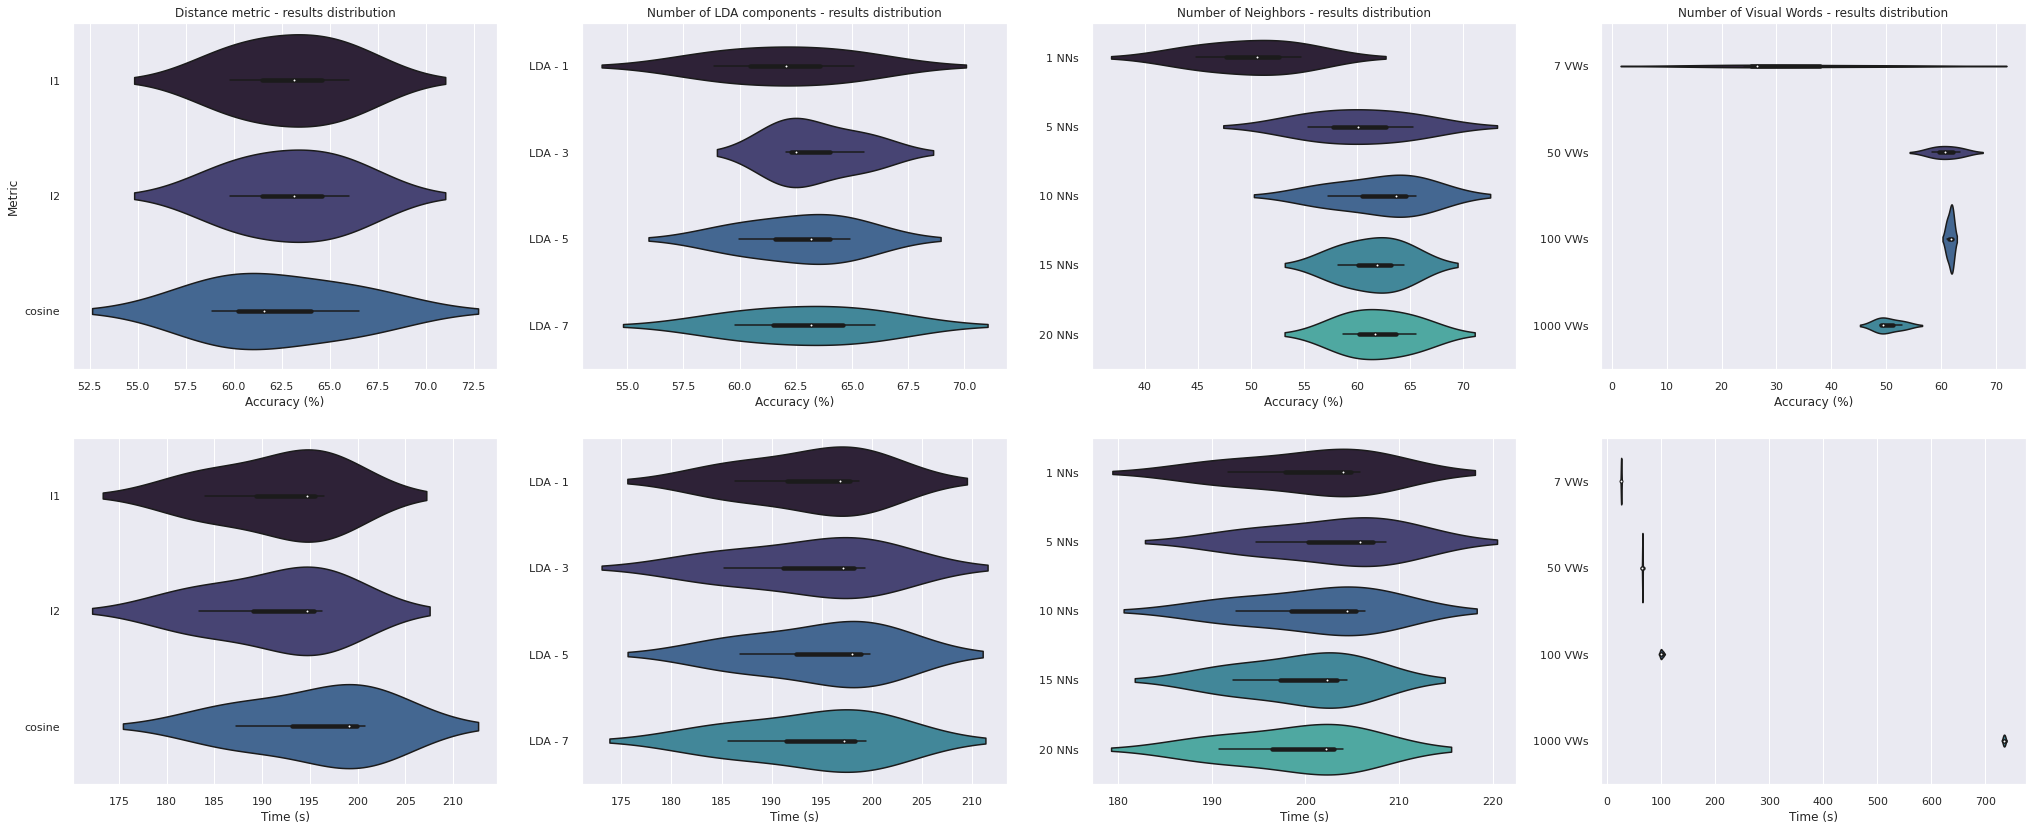

In [9]:
# Plot the results

get_data = lambda arr: (np.concatenate([a[1]['test_score'] for a in arr])) * 100
distance = get_data(dresults)
com_data = get_data(com_results)
nns_data = get_data(nns_results)
book_data = get_data(book_results)

labels = ['l1']*len(dresults[0][1]['test_score'] ) + ['l2'] * len(dresults[1][1]['test_score'] ) + ['cosine']*len(dresults[2][1]['test_score'] )
label_des = ['LDA - 1']*len(com_results[0][1]['test_score']) + ['LDA - 3'] * len(com_results[1][1]['test_score']) + ['LDA - 5'] * len(com_results[2][1]['test_score']) + ['LDA - 7'] * len(com_results[3][1]['test_score'])
labels_nns = []
labels_book = []
for n, nn in enumerate(nns): labels_nns += [f"{nn} NNs"] * len(nns_results[n][1]['test_score'])
for n, s in enumerate(codebook_size): labels_book += [f"{s} VWs"] * len(book_results[n][1]['test_score'])

fig, main_axs = plt.subplots(nrows = 2, ncols= 4, figsize = (35, 14))

main_axs[0][0].set_title('Distance metric - results distribution')
main_axs[0][0].set_ylabel('Metric')
main_axs[0][0].set_xlabel('Accuracy (%)')

main_axs[0][1].set_title('Number of LDA components - results distribution')
main_axs[0][1].set_xlabel('Accuracy (%)')

main_axs[0][2].set_title('Number of Neighbors - results distribution')
main_axs[0][2].set_xlabel('Accuracy (%)')

main_axs[0][3].set_title('Number of Visual Words - results distribution')
main_axs[0][3].set_xlabel('Accuracy (%)')

sns.violinplot(x=distance, y=labels, ax=main_axs[0][0])
sns.violinplot(x=com_data, y=label_des, ax=main_axs[0][1])
sns.violinplot(x=nns_data, y=labels_nns, ax=main_axs[0][2])
sns.violinplot(x=book_data, y=labels_book, ax=main_axs[0][3])


### EXECUTION TIMES ####
get_data_time = lambda arr: (np.concatenate([a[1]['fit_time'] for a in arr]))

main_axs[1][0].set_xlabel('Time (s)')

main_axs[1][1].set_xlabel('Time (s)')

main_axs[1][2].set_xlabel('Time (s)')

main_axs[1][3].set_xlabel('Time (s)')

distance_t = get_data_time(dresults)
com_data_t = get_data_time(com_results)
nns_data_t = get_data_time(nns_results)
book_data_t = get_data_time(book_results)

sns.violinplot(x=distance_t, y=labels, ax=main_axs[1][0])
sns.violinplot(x=com_data_t, y=label_des, ax=main_axs[1][1])
sns.violinplot(x=nns_data_t, y=labels_nns, ax=main_axs[1][2])
sns.violinplot(x=book_data_t, y=labels_book, ax=main_axs[1][3])

plt.show()

In this example we use a small amount of explorations on a controlled environment in the sense that we set a fixed series of parameters and we just tune the one we want to visualize the distributions of. Additionally we'll be showing its performance (time) in each scenario to consider only combinations with a good time/accuracy ratio. This is not the ideal case, therefore we've run 400 random explorations in order to have representative distributions and observe each parameter in all the posible scenarios, resulting in more representative distributions instead of the previous ones, biased to a single combination. Although not being as representative as the following approach, it still has some relevant insights such as the fact that the number of visual words seems to be a concave function, while the number of neighbors does not monotonically increase the performance, but converges given a big enough number.


### Randomized Cross-Validated Search

In the following visualization, as it's been already said, +400 experiments with 3 cross-validated folds have been ran. The large ammount of experiments using a random search technique allows us to assume that all the posible combination of parameters have been tested when fixing one in particular, i.e. if we fix the descriptor to be SIFT, the distribution is representative of all the posible situations involving SIFT and, therefore, it can individually show SIFT's performance.



> Visualizing the behavior of the parameters with a random search can lead to an individual exploration of the best parameters; i.e. when the number of randomly chosen parameters is big enough, the resulting assymptotic distributions for the parameters express their performance depending only on their own value.

In [10]:
def violin_plot(dataframe, targets = ['param_codebook_size', 'param_descriptor'], nbins = [3, None], actual_names = ['codebook size', 'descriptor']):
    # If nbins is None, target continuous variable is assumed.
    assert not 2 * len(targets) - len(nbins) - len(actual_names), 'len(nbins) must be equal to len(targets) and len(actual_names)'
    fig, axs = plt.subplots(nrows=3, ncols=len(targets), figsize = (8 * len(targets), 24))
    dataframe['param_pca_perc'] = dataframe['param_pca_perc'] * 100
    for n, (variable, bins) in enumerate(zip(targets, nbins)):

        valueslut = {y: x  for x, y in enumerate(dataframe[variable].unique())}
        try:
            sns.regplot(data=dataframe, x = variable, y = "mean_test_score", ax = axs[2][n])
        except:

                data = [valueslut[x] for x in dataframe[variable]]
                newcol = f"{variable}-int"
                dataframe[newcol] = data
                if 'param_pca_perc' == variable: datashow = dataframe[dataframe['dim_reducer_type'] == 'PCA']
                else: datashow = dataframe
                sns.regplot(data=datashow, x = newcol, y = "mean_test_score", ax = axs[2][n])
                axs[2][n].set_xticklabels(list(valueslut.keys()))

        if isinstance(bins, int):

            values = dataframe[variable]
            width = int((values.max() - values.min()) / (bins))
            minim, maxim = values.min()//1, int(values.max() + 1)
            intervals = [i for i in range(int(minim), int(maxim), width)]

            binned = pd.cut(values, bins = intervals, include_lowest=1)
            variable = f"{variable}_binned"
            dataframe = dataframe.copy()

            dataframe[variable] = binned

        sns.violinplot(data=dataframe, y=variable, x="mean_test_score", ax = axs[0][n],)
        sns.violinplot(data=dataframe, y=variable, x="mean_fit_time", ax = axs[1][n])


        axs[0][n].set_title(f"Results for: {actual_names[n]}")
        axs[0][n].set_ylabel(actual_names[n])
        axs[1][n].set_ylabel(actual_names[n])
        axs[2][n].set_xlabel(actual_names[n])
        
        axs[0][n].set_xlabel('test score')
        axs[1][n].set_xlabel('fit time')
        axs[2][n].set_ylabel('test score')

    # fig.suptitle('Violin plot of results distributions')
    fig.tight_layout()

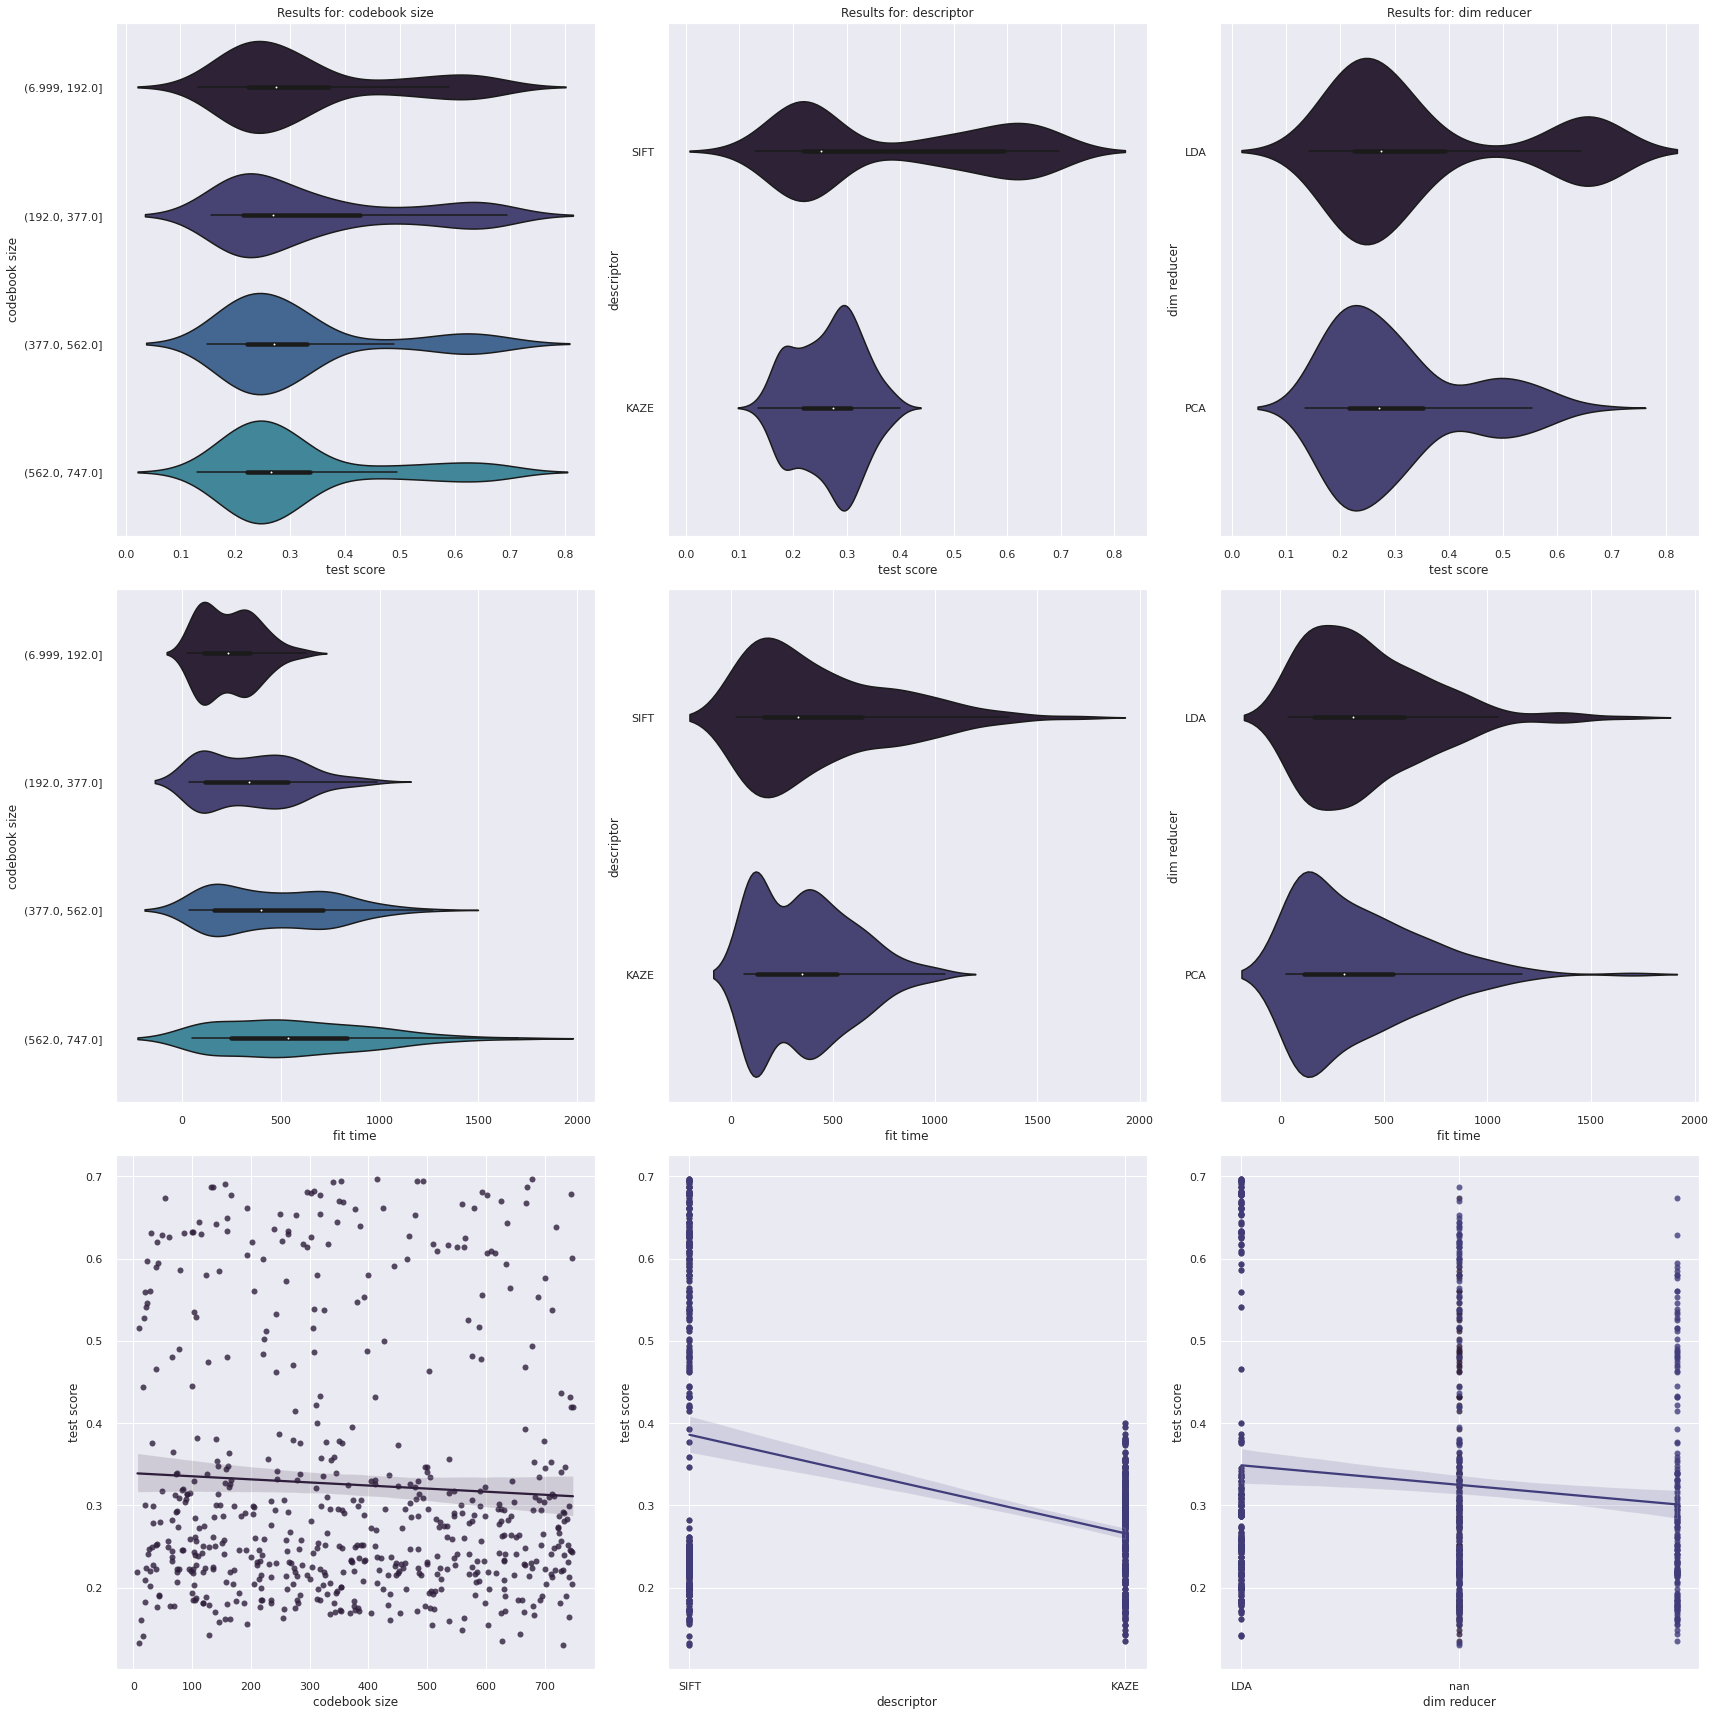

In [11]:
## Load precomputed results and plot them, for hyperparams 'codebook size', 'descriptor', 'dim reducer', 'number of neighbors'
dfs = pd.concat([pd.read_csv(f"results/{r}") for r in os.listdir('./results/') if '.csv' in r])
violin_plot(dfs, ['param_codebook_size', 'param_descriptor', 'param_dim_reducer_type',],
                 [4, None, None,],
                 ['codebook size', 'descriptor', 'dim reducer',])

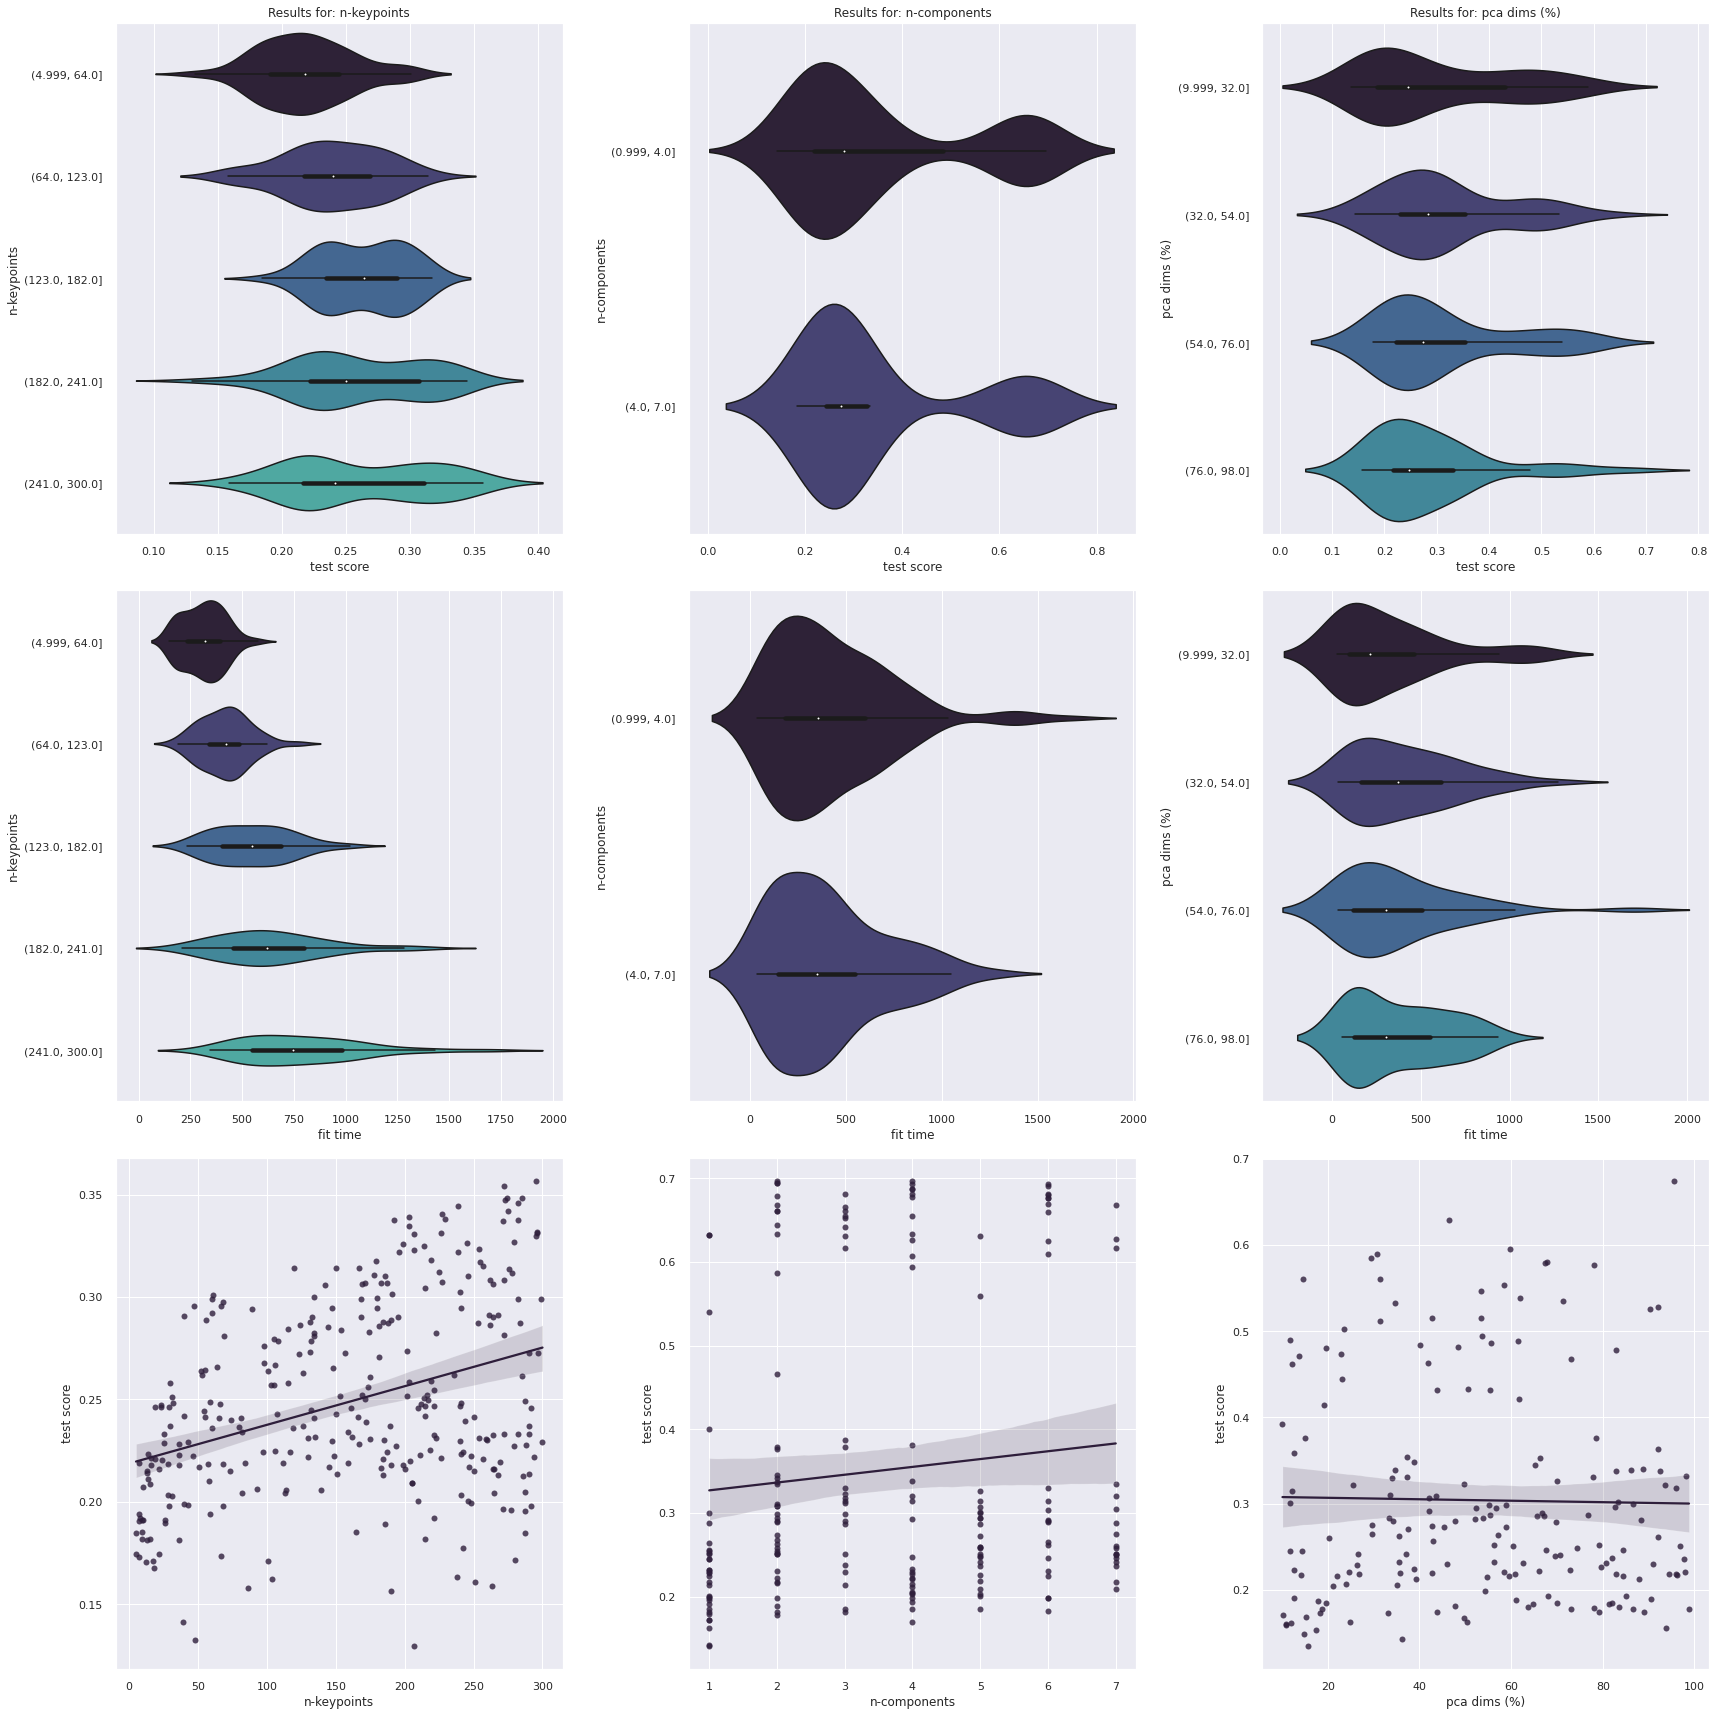

In [12]:
## Load precomputed results and plot them, for hyperparams 'distance metric', 'n-keypoints', 'n-components', 'pca dims (%)'
dfs = pd.concat([pd.read_csv(f"results/{r}") for r in os.listdir('./results/') if '.csv' in r])
violin_plot(dfs, ['param_n_keypoints', 'param_n_components', 'param_pca_perc'],
                 [5, 2, 4],
                 ['n-keypoints', 'n-components', 'pca dims (%)'])

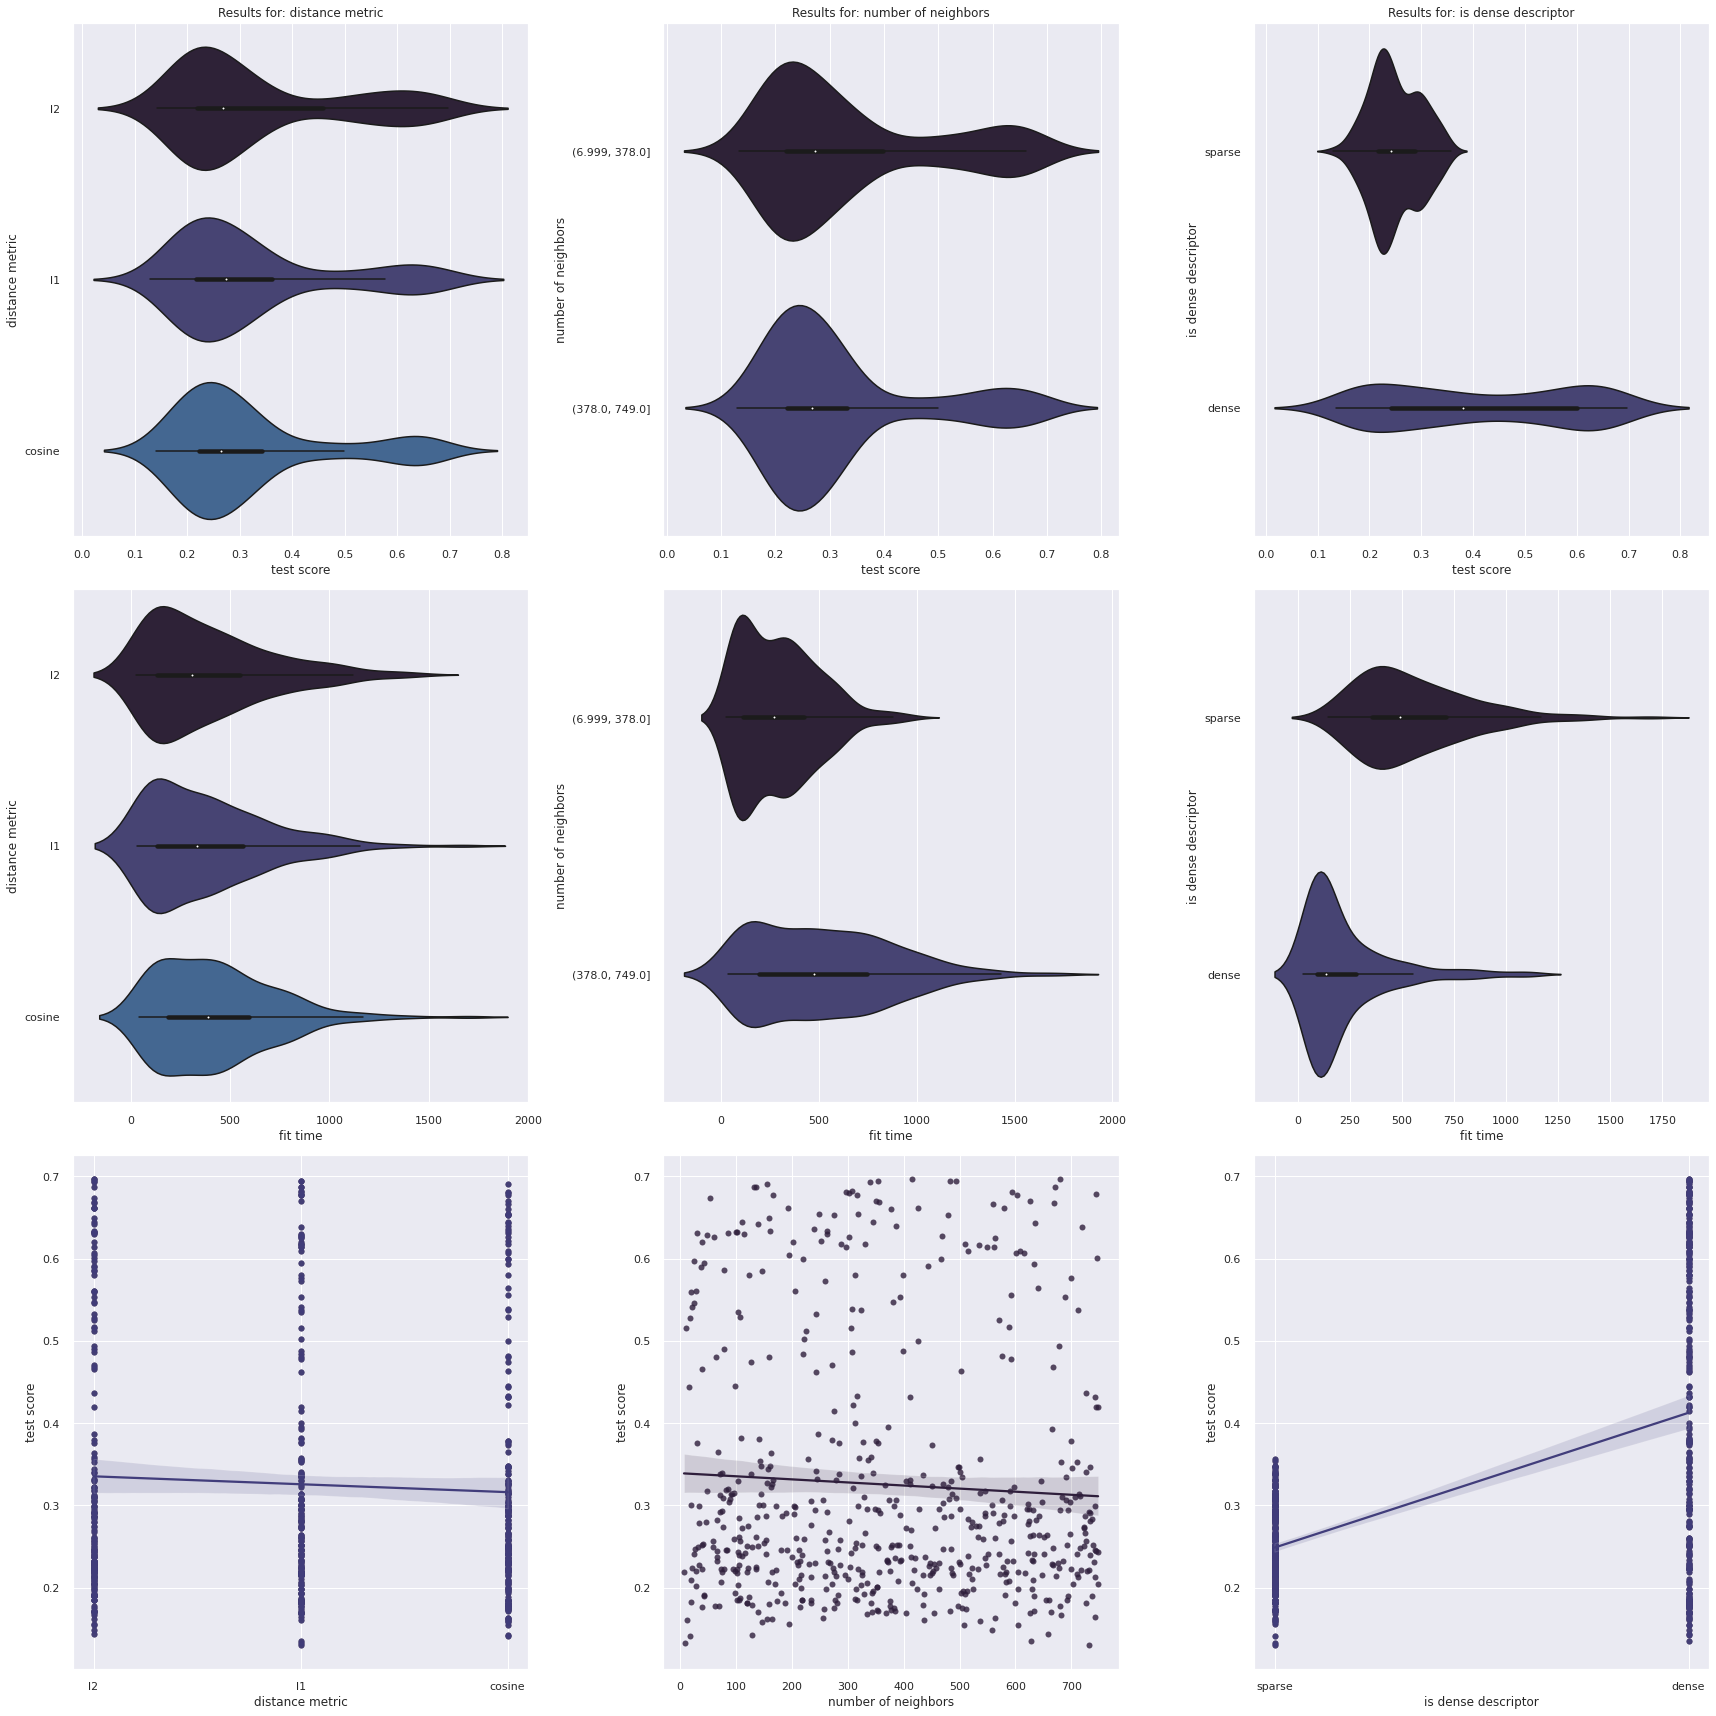

In [26]:
## Load precomputed results and plot them, for hyperparams 'distance metric', 'number of neighbors', 'is dense descriptor'
dfs = pd.concat([pd.read_csv(f"results/{r}") for r in os.listdir('./results/') if '.csv' in r])
dfs['param_dense'] = list(map(lambda x: 'dense' if x else 'sparse', dfs['param_dense'])) 
violin_plot(dfs, ['param_distance_metric', 'param_codebook_size', 'param_dense'],
                 [None, 2, None,],
                 ['distance metric', 'number of neighbors', 'is dense descriptor'])


Although most of the distributions overlap each other, it's still feasible to draw some insights:

* The number of keypoints retrieved from the descriptors are relevant, and although it's close to behave as a direct correlation, it looks like the distribution that maximizes a good performance probability is somewhere in the middle, so the more keypoints you introduce, the greater are the chances you are descriving noise, but there's also a chance you are computing good information, therefore the distribution is way more flat and unstable, interacting the most with other parameters when increasing it beyond this middle point. A large amount of keypoints also slows the process in a scale that may be unconsiderable go beyond 1024 keypoints.

* If we compare the accuracy of dense features against non-dense, regardless of whether we use SIFT or AKAZE, we conclude that dense features perform better.

* The average results on the size of the codebook exploration are not clear, but it's still clear that given a too large number, the performance drops. Since it's a brave assumption to make given the distribution further exploration will be done in this matter.

* It seems that the number of neighbors in the kNN classifier does not have a strong impact on the results, with only marginal gains in accuracy, although at no expense in terms of compute time.

* All three studied distance measures, namely cosine similarity, L1 norm and L2 norm, perform similarly, L2 norm seems to come on top.

* As it will be shown later, the number of components when reducing the embedding size (PCA or LDA) just drops the performance, meaning that there are likely no useless visual words and that it should only be considered in case of speed requirements.

* Despite the fact that its maximum probabilities intersect, it's clear that SIFT is, again, the absolute winner on local descriptors, showing a clear regression line that increases on the direction of SIFT being used and a high probability to outperform KAZE.

As it's been commented above, the size of the codebook is a critical parameter that required further information. It may be unintuitive to think that making your base knowledge about the world more wide has a negative impact on performance. In the case of those parameters for which it's still not clear which values are the best, we'll just take the empirical results from the random search.

In [14]:
# Prepare data for closely visualizing effect of number of visual words.

# VISUALIZE INFLEXION POINT OF N VW
clf = ClassifierBoVW(
    descriptor='SIFT',
    dense=True,  # dense does codebook_sizework with KAZE descriptor
    n_keypoints=1000,
    codebook_size=224,
    n_neighbors=17,
    distance_metric='cosine',
    dim_reducer_type=None,  # 'PCA' or 'LDA'
    pca_perc=128,
    n_components=7,
)

codebook_size = [1, 2, 16, 64, 128, 224, 512, 1024]
if os.path.exists('../vis/curve.pkl',):
    book_results = pickle.load(open('../vis/curve.pkl', 'rb'))
else:

    book_results = run_model_with_params(clf, 'codebook_size', codebook_size, train_dataset.images, train_labels, verbose = True)
    pickle.dump(book_results, open('../vis/curve.pkl', 'wb'))

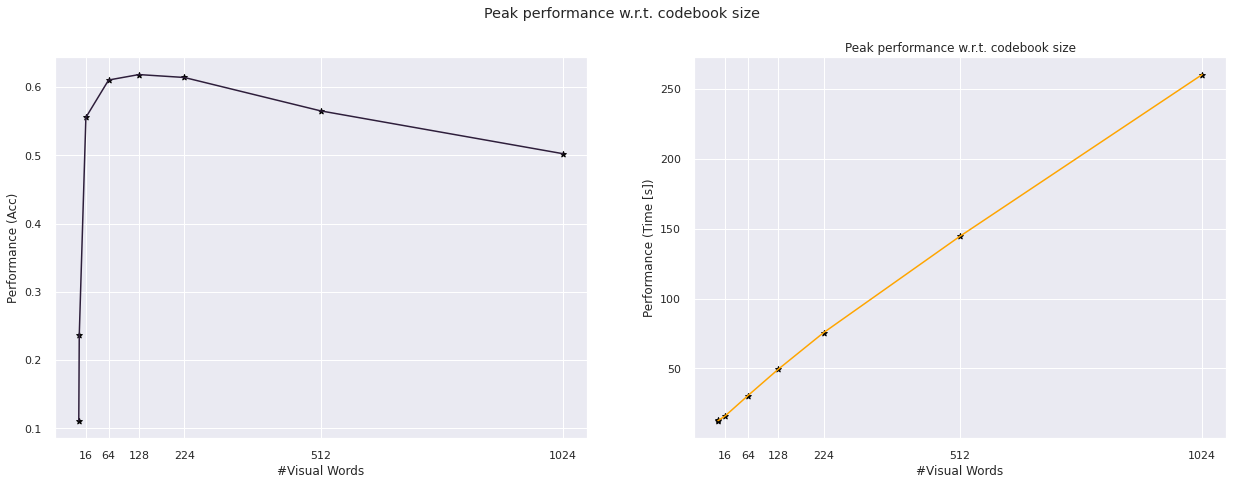

In [15]:
# Visualize effect of number of visal words.

book_data = [x[1]['test_score'].mean() for x in book_results] 
book_data_time = [x[1]['fit_time'].mean() for x in book_results] 

fig, ax = plt.subplots(ncols = 2, figsize = (21, 7))
ax1 = ax[0]
fig.suptitle('Peak performance w.r.t. codebook size')
ax1.scatter(codebook_size, book_data, c = 'black', marker = '*')
ax1.plot(codebook_size, book_data)

ax1.set_ylabel('Performance (Acc)')
ax1.set_xlabel('#Visual Words')

ax1.set_xticks(codebook_size[2:])

ax2 = ax[1]
plt.title('Peak performance w.r.t. codebook size')
ax2.scatter(codebook_size, book_data_time, c = 'black', marker = '*')
ax2.plot(codebook_size, book_data_time, c = 'orange')

ax2.set_ylabel('Performance (Time [s])')
ax2.set_xlabel('#Visual Words')

ax1.set_xticks(codebook_size[2:])
ax2.set_xticks(codebook_size[2:])

plt.show()

One of the key parameters we've observed is the number of visual words, or the size of the visual codebook; since it's related to the ammount of knowledge we collect from the samples (ammount of "new stuff" we can observe), we should expect performance to grow monotonically w.r.t. codebook size.

Against the odds, a too big number of visual words leads to losing performance, wit a peak around ~128 visual words. This is probably due to the fact of using a histogram of visual words where, if there's too many visual words, the histogram is almost flat and contains less information than a more compressed one.
Interestingly, the fitting time grows linearly  with respect the number of visual words, so it's easy to find a good ratio, just focusing on the peak (128). As a matter of fact, it happens faster than expected. The performance of the model drops when passes the 224 visual words threshold. From the mathematical perspective it's due to the fact that the histogram becomes almost flat, since each image will not have to repeat its visual feature twice as another more similar would already exist. From the ML perspective it's related with the specialization, by allowing this much of visual words, each combination of VW already exists on the codebook, making each histogram too narrow to be similar to other histograms in the collection.



The next question we ask is: how does the size of the feature dimensionality relate to the size of the codebook? We expect that more PCA components allow for a better fit, but at which point does performance plateau?

In [16]:
codebook_size = [1, 2, 16, 64, 128, 224, 512, 1024]
pca_dims = [1, 2, 16, 64, 128, 224, 512, 1024]

if os.path.exists('../vis/hm_matrix.pkl'):
    matrix = pickle.load(open('../vis/hm_matrix.pkl', 'rb'))
else:

    warnings.filterwarnings("ignore")
    matrix = np.zeros((len(codebook_size), len(pca_dims)))

    for n, csize in enumerate(codebook_size):
        for m, pdim in enumerate(pca_dims):
            if pdim > csize: continue

            clf = ClassifierBoVW(
                descriptor='SIFT',
                dense=True,  # dense does codebook_sizework with KAZE descriptor
                n_keypoints=1000,
                codebook_size=csize,
                n_neighbors=1,
                distance_metric='l2',
                dim_reducer_type='PCA',
                pca_perc = pdim  # 'PCA' or 'LDA'
            )
            res = run_model_with_params(clf, 'codebook_size', [csize], train_images_filenames, train_labels, verbose = True)
            matrix[n, m] = res[0][1]['test_score'].mean()

In [17]:
# Save results due to big process here
matrix[-1, -1] = .58*.5+.56*.5
pickle.dump(matrix, open('../vis/hm_matrix.pkl', 'wb'))

[]

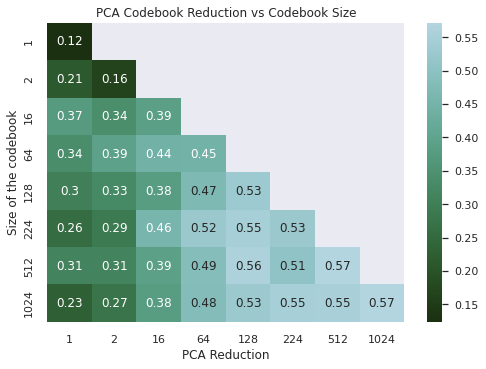

In [18]:
# Plot confusion matrix PCA dim - Codebook size

cmap = sns.cubehelix_palette(start=1.6, light=0.8, as_cmap=True, reverse=True)

ax = sns.heatmap(matrix, annot=True, cmap = cmap, mask = matrix==0)
plt.ylabel('Size of the codebook')
plt.xlabel("PCA Reduction")

ax.set_yticklabels(codebook_size)
ax.set_xticklabels(pca_dims)
plt.title("PCA Codebook Reduction vs Codebook Size")
plt.plot()

We can see that a greater amount of PCA components is only marginally better from 128 dimensions onwards, with a mere 2% increase from 512 to 1024 dimensions. Interestingly, the best trade-off seems to be at 128 visual words and 128 PCA components, with 55% accuracy. 

## Results on the Best Combination of Parameters

We choose the hyperparameter values by looking at the results of the randomized search (find them in the cell below). With this configuration, we fit a final model, compute its test accuracy and plot the confusion matrix.

In [19]:
clf = ClassifierBoVW(
    descriptor='SIFT',
    dense=True,
    step_size=32,
    n_keypoints=32,
    codebook_size=198,
    n_neighbors=15,
    distance_metric='l2',
    dim_reducer_type='LDA',
    n_components=3,
)

In [20]:
clf.fit(train_dataset.images, train_labels)

In [21]:
predictions = clf.predict(test_dataset.images)

In [22]:
test_accuracy = accuracy_score(test_labels, predictions)
print("test accuracy: ", test_accuracy)

test accuracy:  0.6617100371747212


In [23]:
# Prepare data for confusion matrix
axs_dict = {name: n for n, name in enumerate(set(test_labels))}
cat = len(axs_dict)
matrix = np.zeros((cat, cat))
for gt, pred in zip(test_labels, predictions):
    matrix[axs_dict[gt], axs_dict[pred]] += 1

matrixrel = np.zeros((cat, cat))
for x in test_labels:
    for y in predictions:
        matrixrel[axs_dict[x], axs_dict[y]] = round(100 * matrix[axs_dict[x], axs_dict[y]] / matrix[axs_dict[x],].sum())

[]

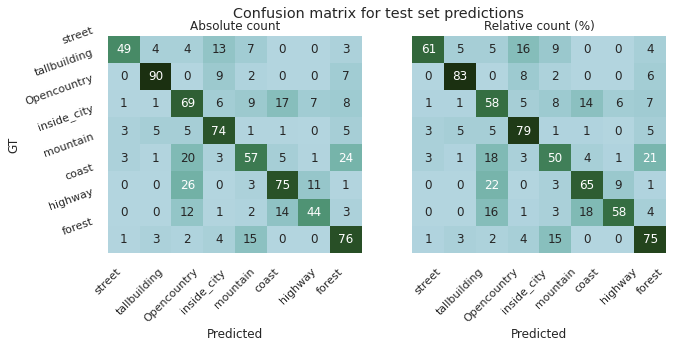

In [24]:
# Plot confusion matrix

cmap = sns.cubehelix_palette(start=1.6, light=0.8, as_cmap=True,)
fig, axs = plt.subplots(ncols = 2, figsize = (10, 4))
ax = axs[0]

sns.heatmap(matrix, annot=True, cmap = cmap, ax = ax, cbar = False)
ax.set_ylabel('GT')
ax.set_xlabel("Predicted")


ax.set_title("Absolute count")
ax.set_xticks(list(range(len(axs_dict))), rotation = 45) # Rotates X-Axis Ticks by 45-degrees
ax.set_yticks(list(range(len(axs_dict))), rotation = 45) # Rotates X-Axis Ticks by 45-degrees


ax.set_yticklabels(axs_dict, rotation = 20)
ax.set_xticklabels(axs_dict, rotation = 45)


sns.heatmap(matrixrel, annot=True, cmap = cmap, ax = axs[1], cbar = False, )
ax = axs[1]
ax.set_title("Relative count (%)")
ax.set_yticklabels([], rotation = 0)
ax.set_xticklabels(axs_dict, rotation = 45)
ax.set_xlabel("Predicted")

fig.suptitle('Confusion matrix for test set predictions')
plt.plot()

From the previous confusion matrix, we can observe that the model has trouble predicting the 'mountain' class as it is often confused with the 'opencountry' and 'forest' classes. This is probably due to the fact that many 'openecountry' and 'forest' images contain mountains and trees, thus some of the visual words in the mountain class are also present in the other two classes. It also happens with the 'opencountry' class, which is often confused with the 'coast' and 'mountain' classes. Again, this may be caused by the fact that many 'opencountry' images contain mountains in the background. Regarding the 'coast' class, it is often confused with the 'opencountry' class, which is probably due to the fact that some 'coast' images contain sand and vegetation, which are also present in the 'opencountry' class. Overall, these classes seem to be the most difficult for the model to predict, as they are often confused with other classes, and other classes are confused for them. Adding more powerful descriptors, such as pyramidal representations and Fisher vectors will help alleviate this lack of discriminative power.